<a href="https://colab.research.google.com/github/dbeltranor/training_projects/blob/main/spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle/
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_api_credentials/kaggle.json ~/.kaggle/kaggle.json

In [3]:
! chmod 600 ~/.kaggle/kaggle.json 

In [4]:
!kaggle competitions download -c spaceship-titanic

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 66.3MB/s]


In [5]:
!unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


#Import the main libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#EDA

* Check the diff columns and their data type
* Verify missing values and think how to fill it
* Check for unique values
* Create new columns if needed
* Dispose unwanted columns
* Graph information

In [8]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [9]:
train.shape

(8693, 14)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [11]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [12]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### Treating mising values
* We will fill the missing venues values with 0 since this we cannot prove any pending charge to be assigned
* We will check the PassengerId vs name to fill VIP status and homeplanet for clients with same name

In [13]:
venues_columns = ['RoomService','FoodCourt',	'ShoppingMall',	'Spa',	'VRDeck']
for venue in venues_columns:
  train[venue] = train[venue].fillna(0)

In [14]:
#Take information from PassengerId series to create 2 new columns
df = train.copy()
df['Group'] = df.PassengerId.apply(lambda x: x.split('_')[0])
df['PP'] = df.PassengerId.apply(lambda x: int(x.split('_')[1]))
df.loc[(df['HomePlanet'].isna()) & (df['PP'] == 1), 'HomePlanet'] = 'Missing Value'

In [15]:
homeplanet_missing_index = df[(df['HomePlanet'].isna()) & (df['PP'] > 1)].index.to_list()
temp_var = ''
for i in homeplanet_missing_index:
  temp_var = df['HomePlanet'].loc[i-1]
  df['HomePlanet'].loc[i] = temp_var

<ipython-input-15-8e62b50bf083>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HomePlanet'].loc[i] = temp_var


In [16]:
#We fill the missing cabin information with NA/NA/NA as "not available" since it is confirmed the posivility of groups not sharing the sambe cabin is real
#We separate the cabin into 3 columns deck/num/side
df.Cabin.fillna('NA/NA/NA', inplace=True)
df['deck'] = df.Cabin.apply(lambda x: x.split('/')[0])
df['num'] = df['Cabin'].apply(lambda x: x.split('/')[1])
df['side'] = df['Cabin'].apply(lambda x: x.split('/')[2])


In [17]:
#Fill CryoSleep with NA - 'Not Available' since not all people in the same group or cabin will be using cryosleep
#VIP will be fill with 50/50 between false and true since this is a boolean value and the missing values are equivalent to 2%
df.CryoSleep.fillna('Missing Information', inplace=True)
df.VIP.fillna(random.choice([False, True]), inplace=True)

In [18]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination     182
Age             179
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
Group             0
PP                0
deck              0
num               0
side              0
dtype: int64

In [19]:
#Apply the same principle as with HomePlanet
df.loc[(df['Destination'].isnull()) & (df['PP'] == 1), 'Destination'] = 'Missing Value'

In [ ]:

destination_missing_index = df[(df['Destination'].isna()) & (df['PP'] > 1)].index.to_list()

temp_value = ''
for i in destination_missing_index:
  temp_value = df['Destination'].loc[i-1] 
  df['Destination'].loc[i] = temp_value

In [21]:
#Fill the Age missing values with uniform random number taking in consideration mean and std
upper = int(df.Age.mean() + df.Age.std())
lower = int(df.Age.mean() - df.Age.std())

df['Age'] = df['Age'].fillna(random.randint(lower, upper))


#Steps before creating/training the model
* Create different graphs
* Drop the columns that we won't use 
* Create dummie variables

In [22]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Group', 'PP', 'deck', 'num', 'side'],
      dtype='object')

In [23]:
X = df.drop(['PassengerId', 'Transported', 'num', 'Cabin', 'Name', 'PP'], axis=1)
y = df.Transported

In [24]:
X.Group = pd.to_numeric(X.Group, errors='coerce')
X_dummies = pd.get_dummies(X, drop_first= True)
X_dummies.head()

,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,HomePlanet_Europa,HomePlanet_Mars,...,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_NA,deck_T,side_P,side_S
0,39.0,False,0.0,0.0,0.0,0.0,0.0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
1,24.0,False,109.0,9.0,25.0,549.0,44.0,2,0,0,...,0,0,0,0,1,0,0,0,0,1
2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,3,1,0,...,0,0,0,0,0,0,0,0,0,1
3,33.0,False,0.0,1283.0,371.0,3329.0,193.0,3,1,0,...,0,0,0,0,0,0,0,0,0,1
4,16.0,False,303.0,70.0,151.0,565.0,2.0,4,0,0,...,0,0,0,0,1,0,0,0,0,1


#Build graphs to explore the data

<Figure size 2000x800 with 0 Axes>

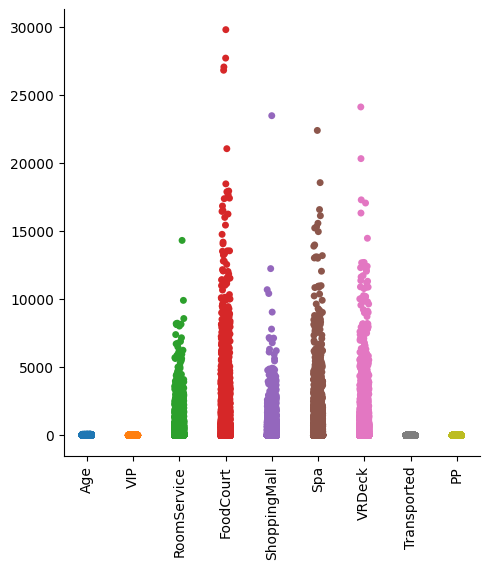

In [25]:
plt.figure(figsize=(20,8))
sns.catplot(df)
plt.xticks(rotation=90)
plt.show()

<ipython-input-26-d0c02e7ff094>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


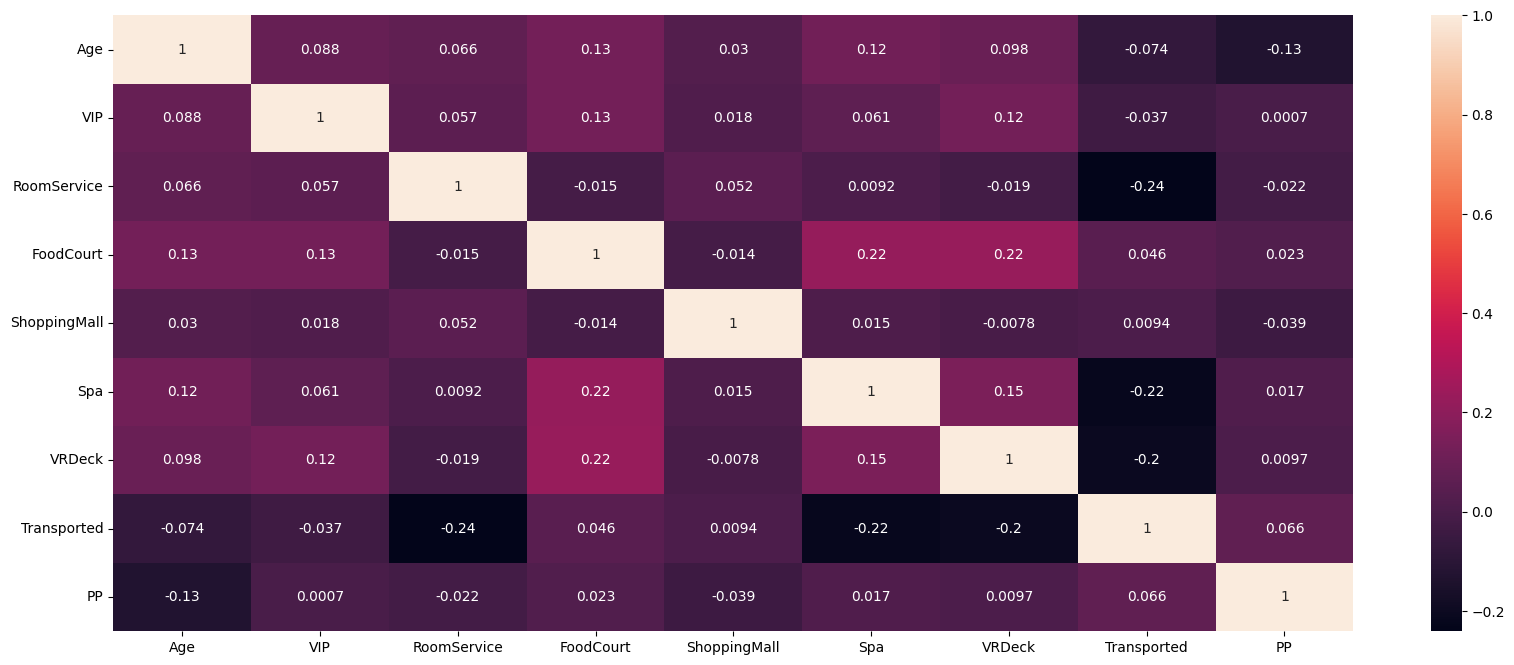

In [26]:
fig = plt.figure(figsize=(20,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

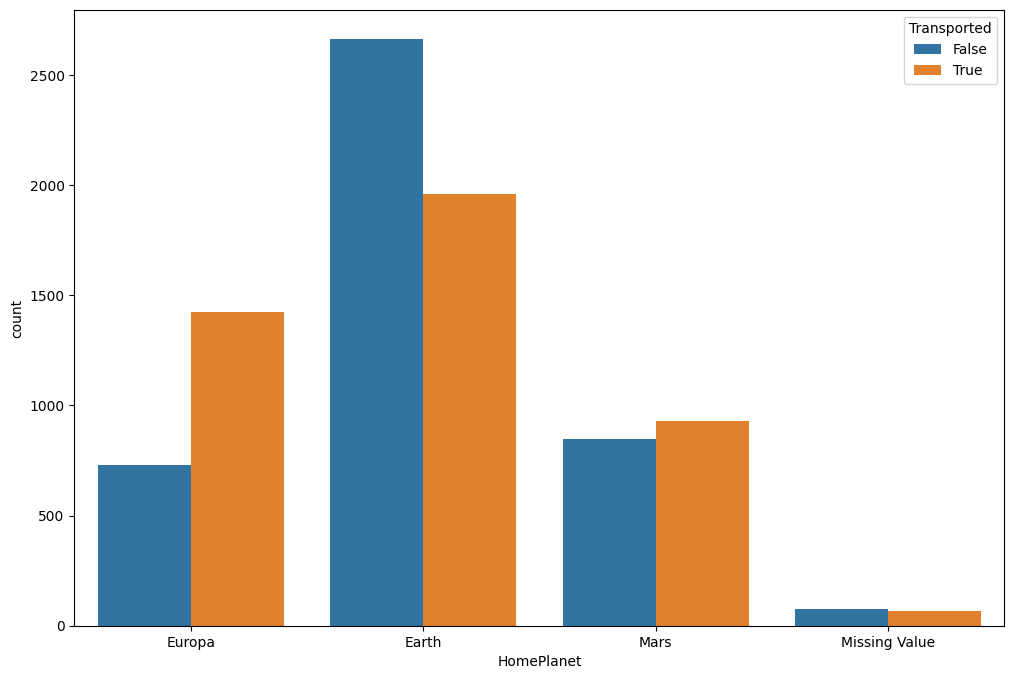

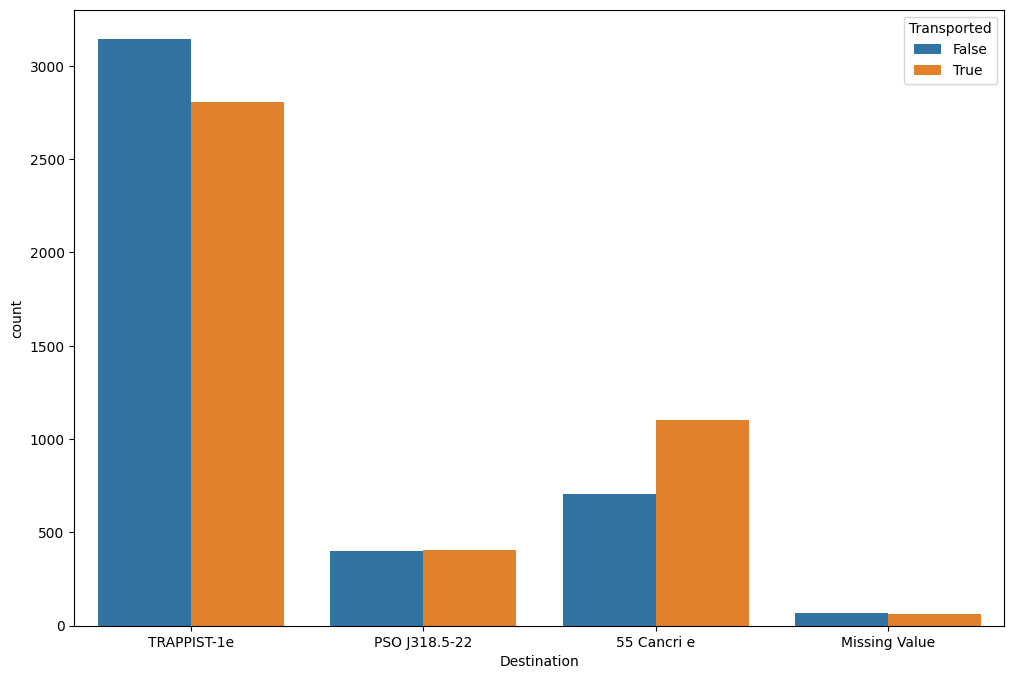

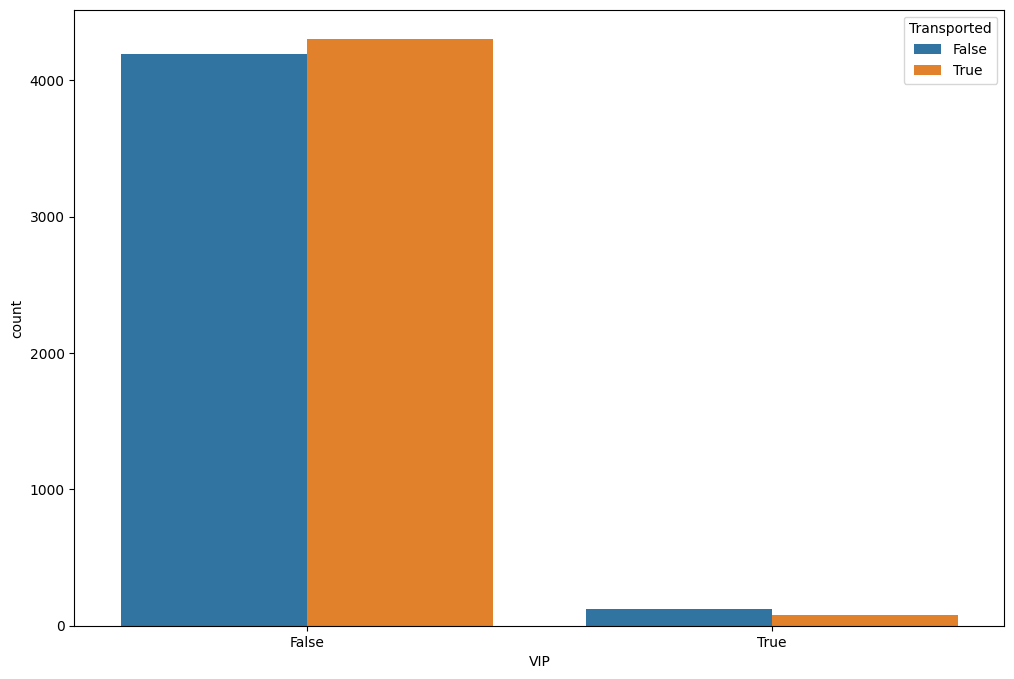

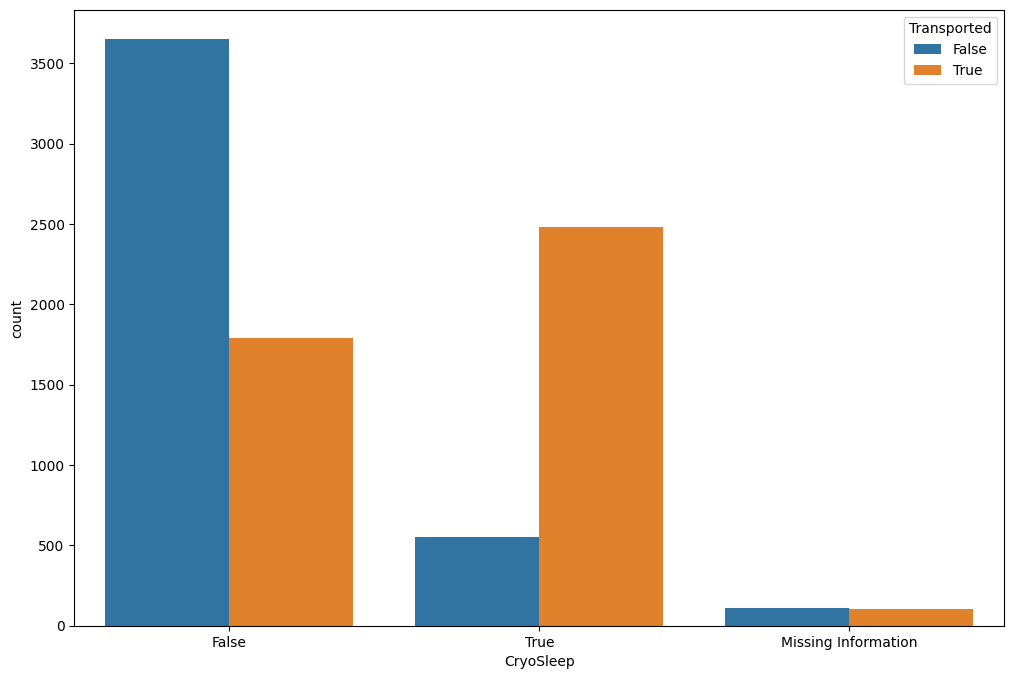

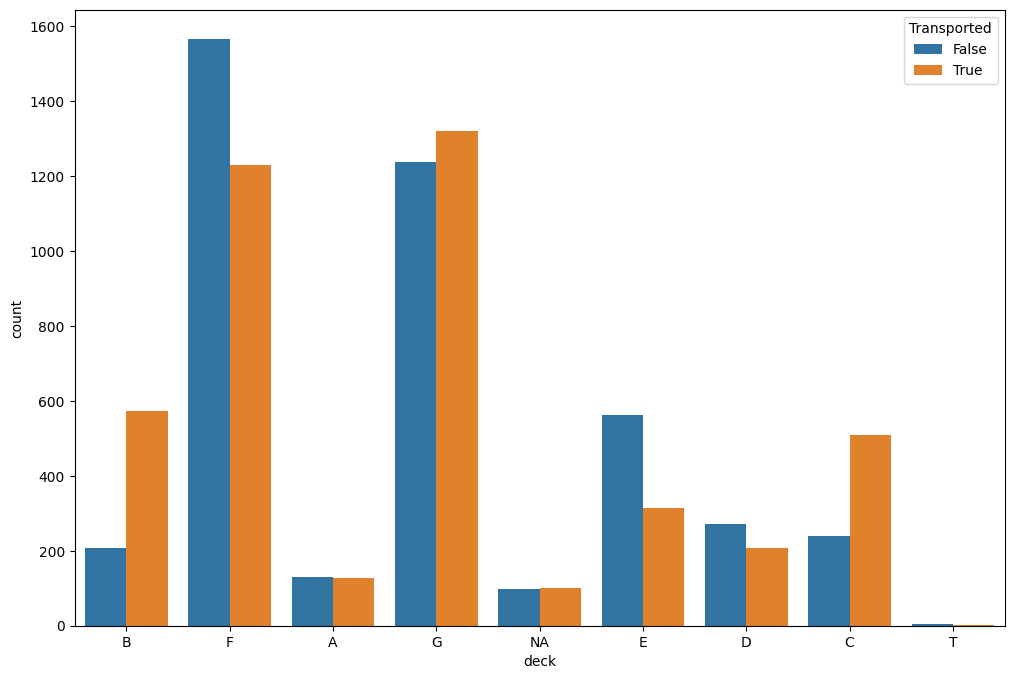

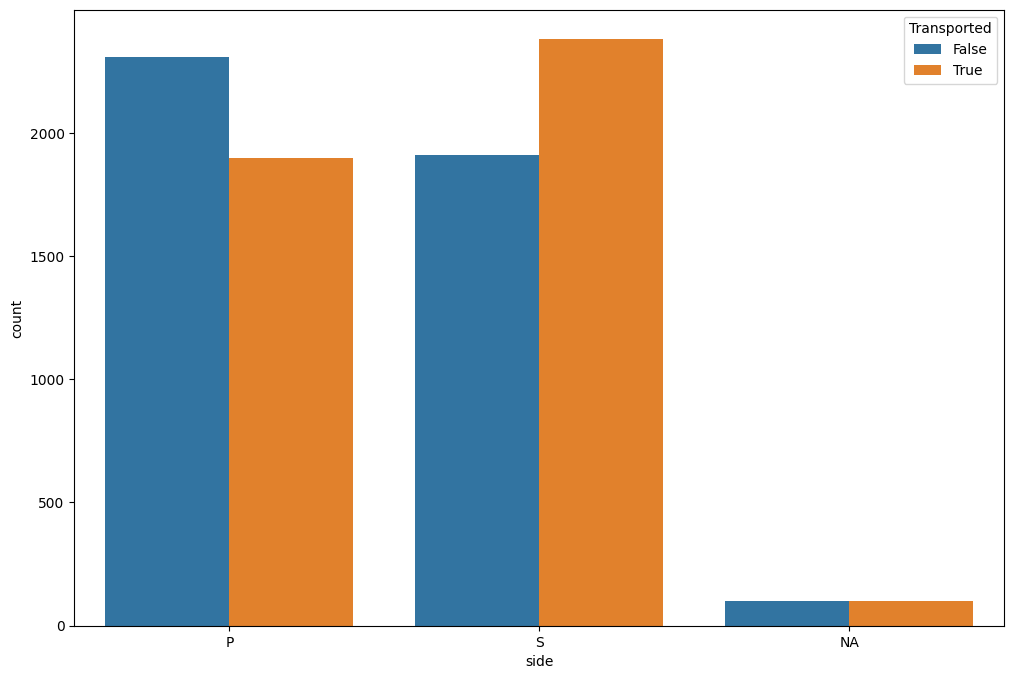

In [27]:
columns_to_graph =['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'deck', 'side']

for i in columns_to_graph:  
  fig = plt.figure(figsize=(12,8))
  sns.countplot(data=df, x=i, hue='Transported')
  plt.show()

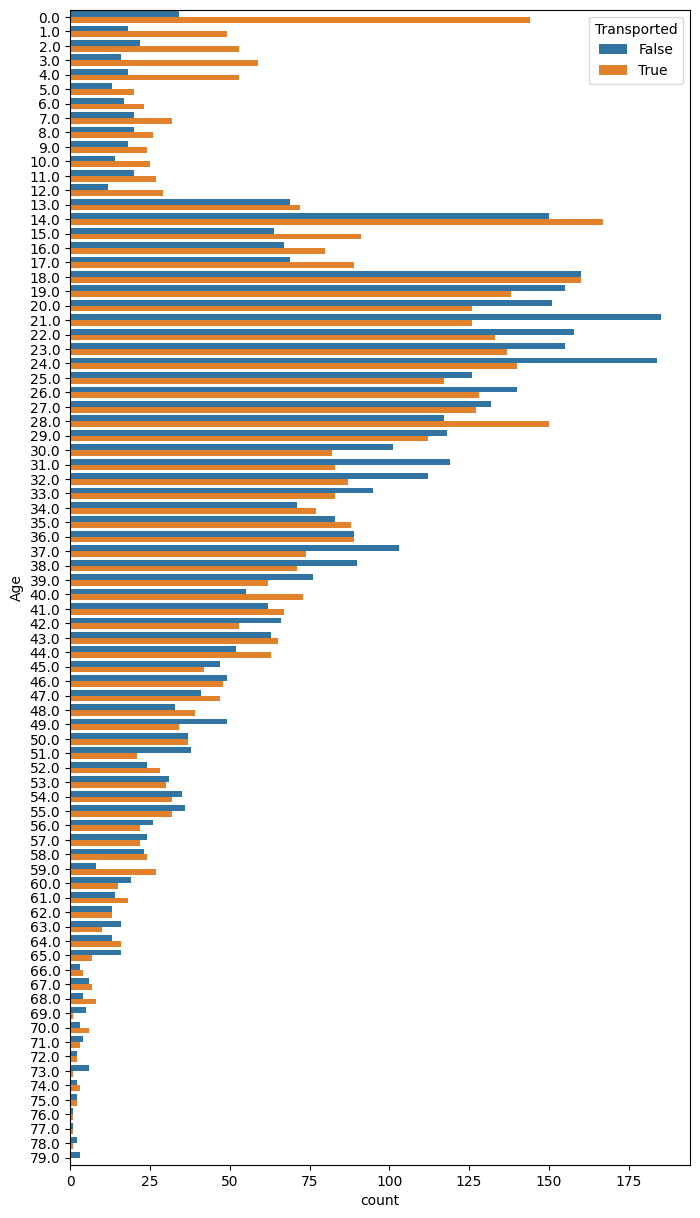

In [ ]:
  fig = plt.figure(figsize=(8,15))
  sns.countplot(data=df, y='Age', hue='Transported')
  plt.show()

We found some tendencies regarding people being transported in the following sections.
* People under 12
* People from Europa
* People under Cryosleep
* Pleople staying on deck B and C.

#Create funtions to ease the test convertion


In [28]:
def convertion_dataframe(data):
  df = data.copy()
  venues_columns = ['RoomService','FoodCourt',	'ShoppingMall',	'Spa',	'VRDeck']
  for venue in venues_columns:
    df[venue] = df[venue].fillna(0)

  df['Group'] = df.PassengerId.apply(lambda x: x.split('_')[0])
  df['PP'] = df.PassengerId.apply(lambda x: int(x.split('_')[1]))
  df.loc[(df['HomePlanet'].isna()) & (df['PP'] == 1), 'HomePlanet'] = 'Missing Value'  

  homeplanet_missing_index = df[(df['HomePlanet'].isna()) & (df['PP'] > 1)].index.to_list()
  temp_var = ''
  for i in homeplanet_missing_index:
    temp_var = df['HomePlanet'].loc[i-1]
    df['HomePlanet'].loc[i] = temp_var

  df.Cabin.fillna('NA/NA/NA', inplace=True)
  df['deck'] = df.Cabin.apply(lambda x: x.split('/')[0])
  df['num'] = df['Cabin'].apply(lambda x: x.split('/')[1])
  df['side'] = df['Cabin'].apply(lambda x: x.split('/')[2])

  df.CryoSleep.fillna('Missing Information', inplace=True)
  df.VIP.fillna(random.choice([False, True]), inplace=True)

  df.loc[(df['Destination'].isnull()) & (df['PP'] == 1), 'Destination'] = 'Missing Value'

  destination_missing_index = df[(df['Destination'].isna()) & (df['PP'] > 1)].index.to_list()

  temp_value = ''
  for i in destination_missing_index:
    temp_value = df['Destination'].loc[i-1] 
    df['Destination'].loc[i] = temp_value

  upper = int(df.Age.mean() + df.Age.std())
  lower = int(df.Age.mean() - df.Age.std())

  df['Age'] = df['Age'].fillna(random.randint(lower, upper))

  return df

In [47]:
def get_xy(df):
  if 'Transported' in df.columns:

    X = df.drop(['PassengerId', 'Transported', 'num', 'Cabin', 'Name', 'PP'], axis=1)
    y = df.Transported

    X.Group = pd.to_numeric(X.Group, errors='coerce')
    X_dummies = pd.get_dummies(X, drop_first= True)
    X_dummies.head()

    return X_dummies, y

  else:
    X = df.drop(['PassengerId', 'num', 'Cabin', 'Name', 'PP'], axis=1)

    X.Group = pd.to_numeric(X.Group, errors='coerce')
    X_dummies = pd.get_dummies(X, drop_first= True)
    X_dummies.head()
  

    return X_dummies

#Time to choose the different models
* Create a pipeline to test parameters on multiple models at once
* Import different models
* compare results

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [31]:
X_dummies_train = X_dummies.copy()
y_train = y.copy() 

In [48]:
test = convertion_dataframe(test)
X_dummies_test = get_xy(test)

In [59]:
scaler = StandardScaler()
log_model = LogisticRegressionCV(cv=3, penalty='l2', max_iter=100000, random_state=101)
svc_model = SVC(random_state=101)
rf_model = RandomForestClassifier(random_state=101)

In [49]:
X_scaled_train = scaler.fit_transform(X_dummies_train)
X_scaled_test = scaler.transform(X_dummies_test)

In [60]:
#Log Model

log_model.fit(X_dummies_train, y_train)
y_predict = log_model.predict(X_dummies_test)
test['Transported'] = y_predict
log_submission = test[['PassengerId', 'Transported']]

In [61]:
log_submission.to_csv('log_submission.csv', index=False)

In [66]:
# SVC Model

svc_model.fit(X_dummies_train, y_train)
y_predict = svc_model.predict(X_dummies_test)
test['Transported'] = y_predict
svc_submission = test[['PassengerId', 'Transported']]

In [67]:
svc_submission.to_csv('svc_submission.csv', index=False)

In [68]:
#Random Forest Model

rf_model.fit(X_dummies_train, y_train)
y_predict = rf_model.predict(X_dummies_test)
test['Transported'] = y_predict
rf_submission = test[['PassengerId', 'Transported']]

In [69]:
rf_submission.to_csv('rf_submission.csv', index=False)

In [70]:
!kaggle competitions submit -c spaceship-titanic -f /content/log_submission.csv -m first_submission
!kaggle competitions submit -c spaceship-titanic -f /content/svc_submission.csv -m second_submission
!kaggle competitions submit -c spaceship-titanic -f /content/rf_submission.csv -m third_submission

100% 56.3k/56.3k [00:00<00:00, 260kB/s]
100% 55.9k/55.9k [00:00<00:00, 276kB/s]
100% 56.6k/56.6k [00:00<00:00, 285kB/s]
Successfully submitted to Spaceship Titanic

#Best Score RF 0.79424
## Log on secod 0.79171
### SVC Last 0.78